In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

tfd = tfp.distributions
np.random.seed(1234)

sns.set(style="white")


In [2]:
print("The GPflow version is {0}".format(gpflow.__version__))
print("The tensorflow version is {0}".format(tf.__version__))
print("The tensorflow-probability version is {0}".format(tfp.__version__))

The GPflow version is 2.1.1
The tensorflow version is 2.3.1
The tensorflow-probability version is 0.11.0


In [3]:
# When run in my desktop
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Load Datasets US

The second data come from microsoft [link](https://github.com/microsoft/Bing-COVID-19-Data). This set includes recovered, so we can calculate the number of infected, recovered and susceptible as a function of time. 

In [4]:
mobility_data = pd.read_csv("./Data/Google/Global_Mobility_Report.csv", encoding = "ISO-8859-1")
mobility_data["date"] = pd.to_datetime(mobility_data["date"], format='%d/%m/%Y')

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv("./Data/Microsoft/COVID_CASES.csv", encoding = "ISO-8859-1")
ms_covid["Updated"] = pd.to_datetime(ms_covid["Updated"], format='%m/%d/%Y')
ms_covid = ms_covid[(ms_covid.Country_Region=="United States") & (ms_covid.AdminRegion1.isnull())]
ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "Deaths", "Recovered"]]

Is the computation of the three states correct?

I = {Cumulative Confirmed (cases) - Cumulative Deaths - Cumulative Recovered}

S = 328mil (US pop) - I

In [6]:
# Create the 3 categories S, I, R for US data (UK does not include R)
ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "Deaths", "Recovered"]]
ms_covid.fillna(0, inplace=True)
ms_covid["I"] = ms_covid["Confirmed"] - ms_covid["Deaths"] - ms_covid["Recovered"]
ms_covid["Daily"] = ms_covid["Confirmed"].diff(1)
ms_covid["Daily"].fillna(1, inplace=True)

ms_covid["S"] = 328000000 - ms_covid["I"]

# Create a time variable
# If we have a weekend then assign 0 or weekday 1
ms_covid["Date_number"] = ms_covid.Updated.dt.dayofyear - 20
ms_covid["WEEKDAY"] = 0
ms_covid.loc[ms_covid.Updated.dt.dayofweek < 5, "WEEKDAY"] = 1
ms_covid["WEEKDAY"] = ms_covid["WEEKDAY"]

In [7]:
# drop the last value because it looks wrong
ms_covid = ms_covid[:-1].copy()

In [8]:
# US
ms_covid.dtypes

Updated        datetime64[ns]
Confirmed               int64
Deaths                float64
Recovered             float64
I                     float64
Daily                 float64
S                     float64
Date_number             int64
WEEKDAY                 int64
dtype: object

In [8]:
mobility_data.dtypes

country_region_code                                           object
country_region                                                object
sub_region_1                                                  object
sub_region_2                                                  object
metro_area                                                    object
iso_3166_2_code                                               object
census_fips_code                                             float64
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

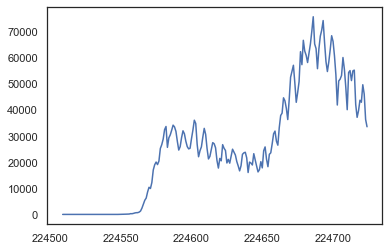

In [9]:
plt.plot(ms_covid.Daily)

# Explore the Google Mobility Dataset

From the Google Mobility data we keep only the general UK cases. We do not go down to LAD (lower administrative level).

We do the same for the US cases

In [10]:
mobility_data_us = mobility_data[(mobility_data.country_region=="United States") & (mobility_data.sub_region_1.isnull())]
mobility_data_us = mobility_data_us.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
mobility_data_us.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [11]:
# transform the data to pct change
mobility_data_us[mobility_data_us.columns[1:]] = mobility_data_us[mobility_data_us.columns[1:]].apply(lambda x: x/100 + 1)

In [11]:
data_us = pd.DataFrame(mobility_data_us["date"])

Merge the Google mobility data to HOME, WORK, and OTHER, with the OTHER to include parks, transit, retail and grocery. 

In [12]:
data_us["HOME"] = mobility_data_us['residential_percent_change_from_baseline'].copy()
data_us["WORK"] = mobility_data_us['workplaces_percent_change_from_baseline'].copy()
data_us["OTHER"] = mobility_data_us.iloc[:,1:5].mean(axis=1)

# Visually explore the dataset

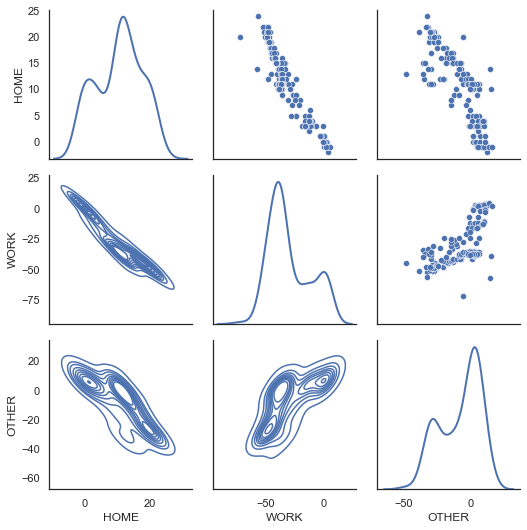

In [13]:
g = sns.PairGrid(data_us, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

In [14]:
data_us.corr()

,HOME,WORK,OTHER
HOME,1.000000,-0.947943,-0.790674
WORK,-0.947943,1.000000,0.667364
OTHER,-0.790674,0.667364,1.000000


# Merge the Datasets

In [15]:
ms_covid.dtypes

Updated        datetime64[ns]
Confirmed               int64
Deaths                float64
Recovered             float64
I                     float64
Daily                 float64
S                     float64
Date_number             int64
WEEKDAY                 int64
dtype: object

In [16]:
data_us.dtypes

date     datetime64[ns]
HOME            float64
WORK            float64
OTHER           float64
dtype: object

Merge the two datasets, the MS covid US and the Google mobility by date

In [17]:
final_data_us = ms_covid.merge(data_us, how='left', left_on='Updated', right_on='date') 
final_data_us.drop(["date"], axis=1, inplace=True)

In [18]:
# Clear NA rows
final_data_us = final_data_us.iloc[24:188,:].copy()

In [19]:
final_data_us.dtypes

Updated        datetime64[ns]
Confirmed               int64
Deaths                float64
Recovered             float64
I                     float64
Daily                 float64
S                     float64
Date_number             int64
WEEKDAY                 int64
HOME                  float64
WORK                  float64
OTHER                 float64
dtype: object

Merge the two datasets, UK mobility and ONS covid

## Create Dataset for Training

In [20]:
final_data_us["SI"] = final_data_us.S*final_data_us.I

final_data_us["Confirmed"] = final_data_us["Confirmed"].astype("float64")
final_data_us["Date_number"] = final_data_us["Date_number"].astype("float64")
final_data_us["WEEKDAY"] = final_data_us["WEEKDAY"].astype("float64")
final_data_us.dtypes

Updated        datetime64[ns]
Confirmed             float64
Deaths                float64
Recovered             float64
I                     float64
Daily                 float64
S                     float64
Date_number           float64
WEEKDAY               float64
HOME                  float64
WORK                  float64
OTHER                 float64
SI                    float64
dtype: object

In [21]:
final_data_us

,Updated,Confirmed,Deaths,Recovered,I,Daily,S,Date_number,WEEKDAY,HOME,WORK,OTHER,SI
24,2020-02-15,15.0,1.0,0.0,14.0,0.0,327999986.0,26.0,0.0,-1.0,2.0,6.50,4.592000e+09
25,2020-02-16,15.0,1.0,0.0,14.0,0.0,327999986.0,27.0,0.0,-1.0,0.0,6.50,4.592000e+09
26,2020-02-17,18.0,2.0,0.0,16.0,3.0,327999984.0,28.0,1.0,5.0,-24.0,6.25,5.248000e+09
27,2020-02-18,21.0,2.0,3.0,16.0,3.0,327999984.0,29.0,1.0,1.0,0.0,1.50,5.248000e+09
28,2020-02-19,24.0,2.0,3.0,19.0,3.0,327999981.0,30.0,1.0,0.0,1.0,2.75,6.232000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-23,3973169.0,133151.0,1226670.0,2613348.0,70719.0,325386652.0,185.0,1.0,11.0,-37.0,2.00,8.503486e+14
184,2020-07-24,4047529.0,134301.0,1252170.0,2661058.0,74360.0,325338942.0,186.0,1.0,11.0,-37.0,1.00,8.657458e+14
185,2020-07-25,4113473.0,135286.0,1277437.0,2700750.0,65944.0,325299250.0,187.0,0.0,4.0,-13.0,8.75,8.785519e+14
186,2020-07-26,4172104.0,135838.0,1296612.0,2739654.0,58631.0,325260346.0,188.0,0.0,3.0,-16.0,4.75,8.911008e+14


## Kernel and Mobility Data

<AxesSubplot:>

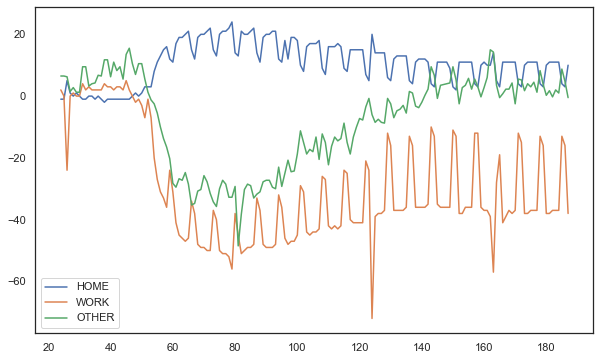

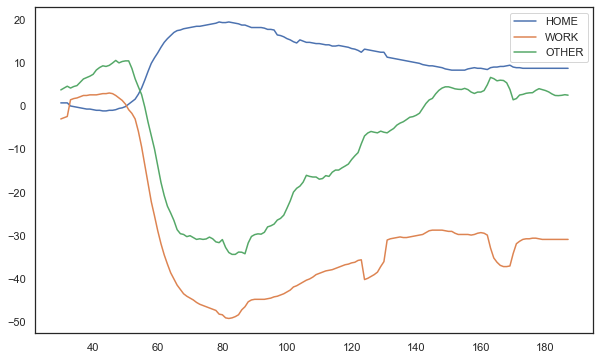

In [22]:
final_data_us[["HOME", "WORK", "OTHER"]].plot(figsize=(10,6))
final_data_us[["HOME", "WORK", "OTHER"]].rolling(7).mean().plot(figsize=(10,6))

There is a clear pattern during the weekends, HOME mobility tends to normalise during the weekends, falling back to the benchmark value. Whereas, in the weekdays we see that mobility has increased during lockdown. 

The opposite stands for the work, whereas OTHER is less clear. 

Maybe if we use a moving average will be better. See how a MA affects the kernel

In [24]:
final_data_us.loc[:, final_data_us.columns.isin(["HOME", "WORK", "OTHER"])].rolling(7).mean().fillna(1)

,HOME,WORK,OTHER
24,1.000000,1.000000,1.000000
25,1.000000,1.000000,1.000000
26,1.000000,1.000000,1.000000
27,1.000000,1.000000,1.000000
28,1.000000,1.000000,1.000000
...,...,...,...
183,1.087143,0.691429,1.024286
184,1.087143,0.691429,1.023929
185,1.087143,0.691429,1.024643
186,1.087143,0.691429,1.026071


In [103]:
### Original Mobility Data Kernels

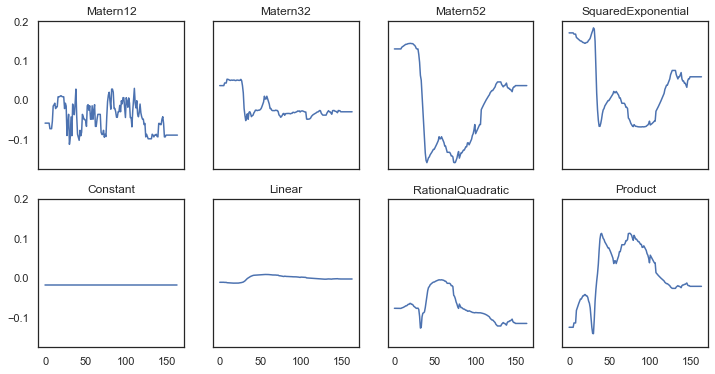

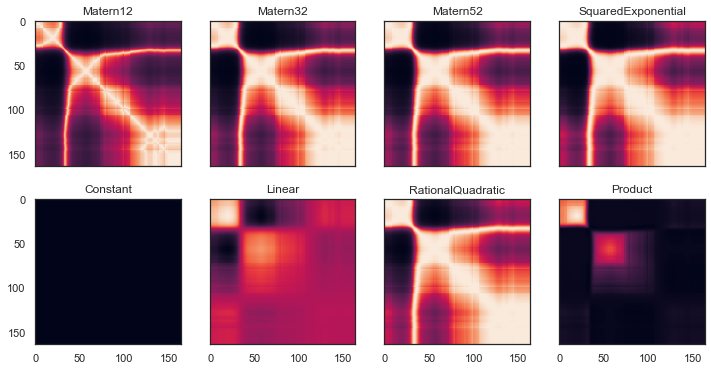

In [23]:
SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

def plotkernels(kernel, data, ax, ma=False, xmin=-3, xmax=3, cov=False):
    data = data.copy()
    if ma==True:
        data_ma = data.loc[:, data.columns.isin(["HOME", "WORK", "OTHER"])].rolling(7).mean().fillna(1)
        data.loc[:, data_ma.columns] = data_ma.copy()
        
    if data.shape[1]>1:
        data = data.to_numpy()
    else:
        data = data.to_numpy().reshape((-1, 1))
        

    
    data = (data - data.mean(axis=0))/data.std(axis=0)
    
    K = kernel(data)
    if cov==False:
        # Show samples from the GP prior with Kernel K
        ax.plot(np.mean(np.random.multivariate_normal(np.zeros(data.shape[0]), K, 100).T, axis=1))
    else:
        # Show the covariance matrix of Kernel K
        ax.imshow(K)
    ax.set_title(kernel.__class__.__name__)

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["HOME"]], ma=True, ax=axes[0, 0])
plotkernels(gpflow.kernels.Matern32(), final_data_us[["HOME"]], ma=True, ax=axes[0, 1])
plotkernels(gpflow.kernels.Matern52(), final_data_us[["HOME"]], ma=True, ax=axes[0, 2])
plotkernels(gpflow.kernels.RBF(), final_data_us[["HOME"]], ma=True, ax=axes[0, 3])
plotkernels(gpflow.kernels.Constant(), final_data_us[["HOME"]], ma=True, ax=axes[1, 0])
plotkernels(gpflow.kernels.Linear(), final_data_us[["HOME"]], ma=True, ax=axes[1, 1])
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["HOME"]], ma=True, ax=axes[1, 2])
plotkernels(k, final_data_us[["HOME"]], ma=True, ax=axes[1, 3])

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["HOME"]], ma=True, ax=axes[0, 0], cov=True)
plotkernels(gpflow.kernels.Matern32(), final_data_us[["HOME"]], ma=True, ax=axes[0, 1], cov=True)
plotkernels(gpflow.kernels.Matern52(), final_data_us[["HOME"]], ma=True, ax=axes[0, 2], cov=True)
plotkernels(gpflow.kernels.RBF(), final_data_us[["HOME"]], ma=True, ax=axes[0, 3], cov=True)
plotkernels(gpflow.kernels.Constant(), final_data_us[["HOME"]], ma=True, ax=axes[1, 0], cov=True)
plotkernels(gpflow.kernels.Linear(), final_data_us[["HOME"]], ma=True, ax=axes[1, 1], cov=True)
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["HOME"]], ma=True, ax=axes[1, 2], cov=True)
plotkernels(k, final_data_us[["HOME"]], ma=True, ax=axes[1, 3], cov=True)


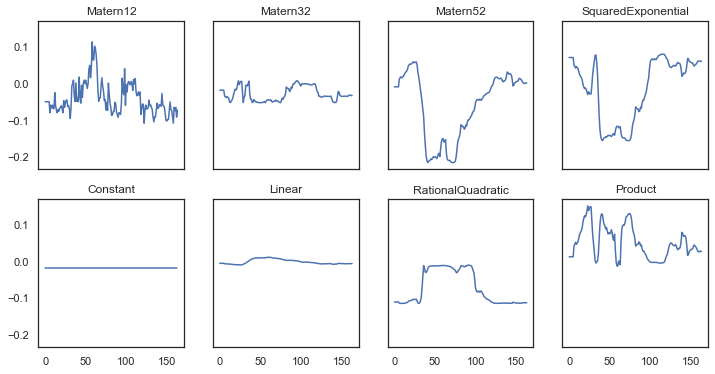

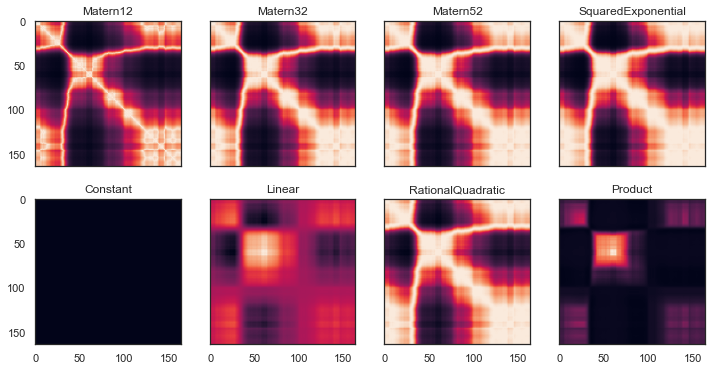

In [24]:
np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 0])
plotkernels(gpflow.kernels.Matern32(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 1])
plotkernels(gpflow.kernels.Matern52(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 2])
plotkernels(gpflow.kernels.RBF(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 3])
plotkernels(gpflow.kernels.Constant(), final_data_us[["OTHER"]], ma=True, ax=axes[1, 0])
plotkernels(gpflow.kernels.Linear(), final_data_us[["OTHER"]], ma=True, ax=axes[1, 1])
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["OTHER"]], ma=True, ax=axes[1, 2])
plotkernels(k, final_data_us[["OTHER"]], ma=True, ax=axes[1, 3])

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 0], cov=True)
plotkernels(gpflow.kernels.Matern32(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 1], cov=True)
plotkernels(gpflow.kernels.Matern52(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 2], cov=True)
plotkernels(gpflow.kernels.RBF(), final_data_us[["OTHER"]], ma=True, ax=axes[0, 3], cov=True)
plotkernels(gpflow.kernels.Constant(), final_data_us[["OTHER"]], ma=True, ax=axes[1, 0], cov=True)
plotkernels(gpflow.kernels.Linear(), final_data_us[["OTHER"]], ma=True, ax=axes[1, 1], cov=True)
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["OTHER"]], ma=True, ax=axes[1, 2], cov=True)
plotkernels(k, final_data_us[["OTHER"]], ma=True, ax=axes[1, 3], cov=True)

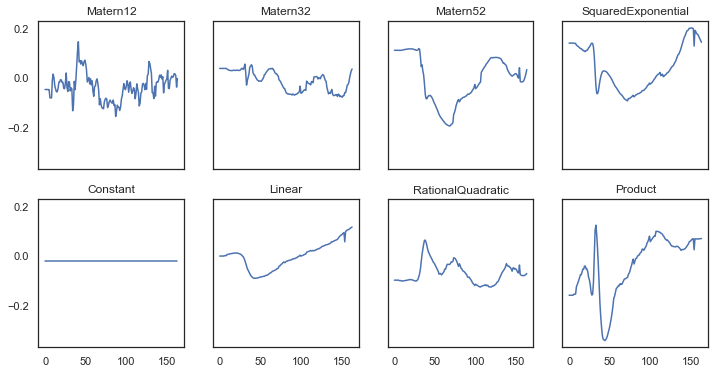

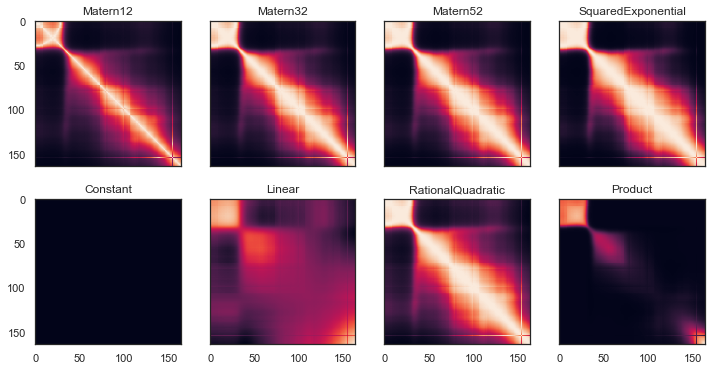

In [25]:
np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 0])
plotkernels(gpflow.kernels.Matern32(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 1])
plotkernels(gpflow.kernels.Matern52(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 2])
plotkernels(gpflow.kernels.RBF(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 3])
plotkernels(gpflow.kernels.Constant(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 0])
plotkernels(gpflow.kernels.Linear(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 1])
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 2])
plotkernels(k, final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 3])

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 0], cov=True)
plotkernels(gpflow.kernels.Matern32(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 1], cov=True)
plotkernels(gpflow.kernels.Matern52(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 2], cov=True)
plotkernels(gpflow.kernels.RBF(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[0, 3], cov=True)
plotkernels(gpflow.kernels.Constant(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 0], cov=True)
plotkernels(gpflow.kernels.Linear(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 1], cov=True)
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 2], cov=True)
plotkernels(k, final_data_us[["SI", "HOME"]], ma=True, ax=axes[1, 3], cov=True)

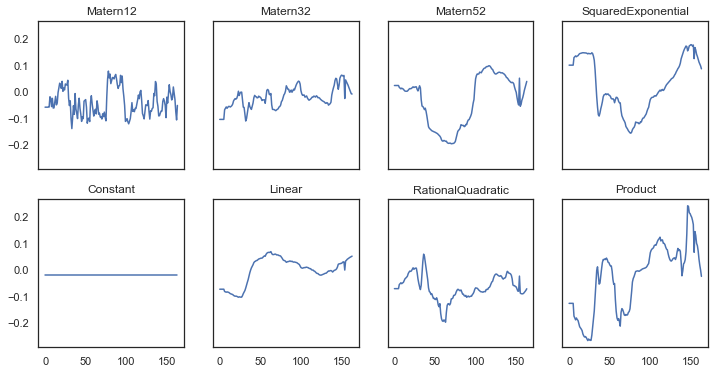

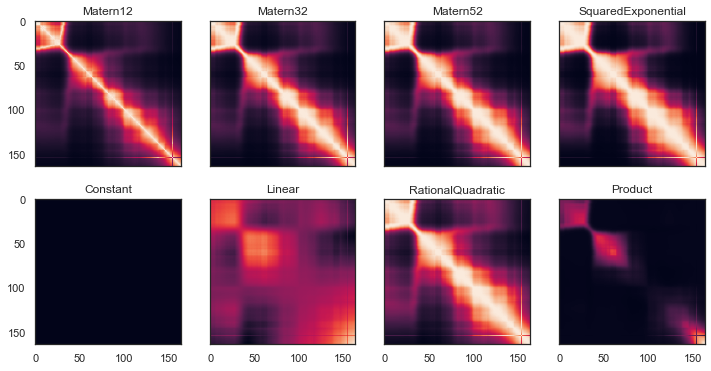

In [26]:
np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 0])
plotkernels(gpflow.kernels.Matern32(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 1])
plotkernels(gpflow.kernels.Matern52(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 2])
plotkernels(gpflow.kernels.RBF(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 3])
plotkernels(gpflow.kernels.Constant(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 0])
plotkernels(gpflow.kernels.Linear(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 1])
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 2])
plotkernels(k, final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 3])

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 0], cov=True)
plotkernels(gpflow.kernels.Matern32(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 1], cov=True)
plotkernels(gpflow.kernels.Matern52(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 2], cov=True)
plotkernels(gpflow.kernels.RBF(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[0, 3], cov=True)
plotkernels(gpflow.kernels.Constant(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 0], cov=True)
plotkernels(gpflow.kernels.Linear(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 1], cov=True)
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 2], cov=True)
plotkernels(k, final_data_us[["SI", "OTHER"]], ma=True, ax=axes[1, 3], cov=True)

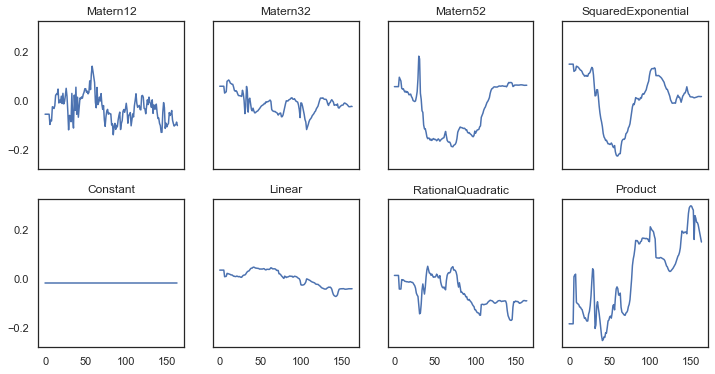

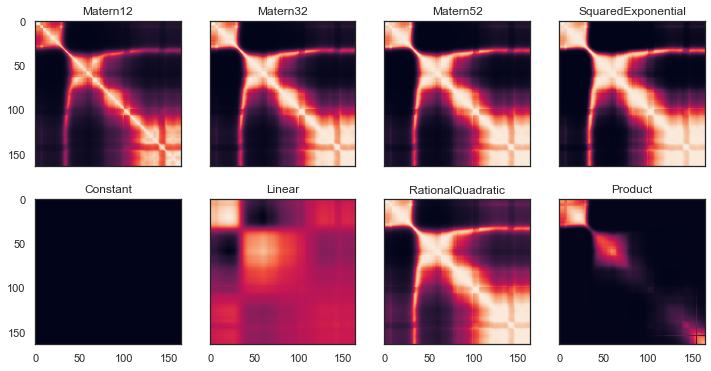

In [27]:
np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 0])
plotkernels(gpflow.kernels.Matern32(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 1])
plotkernels(gpflow.kernels.Matern52(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 2])
plotkernels(gpflow.kernels.RBF(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 3])
plotkernels(gpflow.kernels.Constant(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 0])
plotkernels(gpflow.kernels.Linear(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 1])
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 2])
plotkernels(k, final_data_us[["SI", "WORK", "OTHER"]], ma=True, ax=axes[1, 3])

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 0], cov=True)
plotkernels(gpflow.kernels.Matern32(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 1], cov=True)
plotkernels(gpflow.kernels.Matern52(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 2], cov=True)
plotkernels(gpflow.kernels.RBF(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 3], cov=True)
plotkernels(gpflow.kernels.Constant(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 0], cov=True)
plotkernels(gpflow.kernels.Linear(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 1], cov=True)
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 2], cov=True)
plotkernels(k, final_data_us[["SI", "WORK", "OTHER"]], ma=True, ax=axes[1, 3], cov=True)

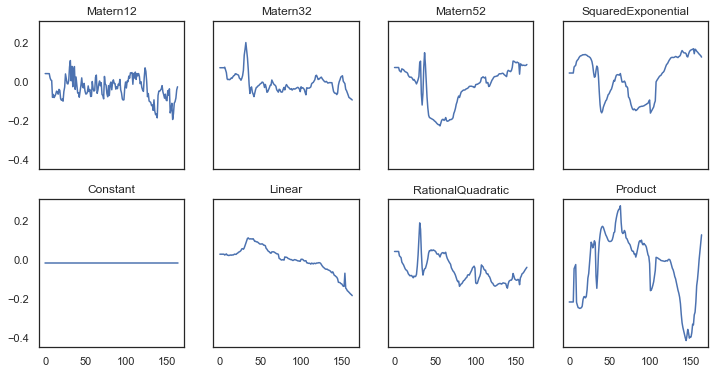

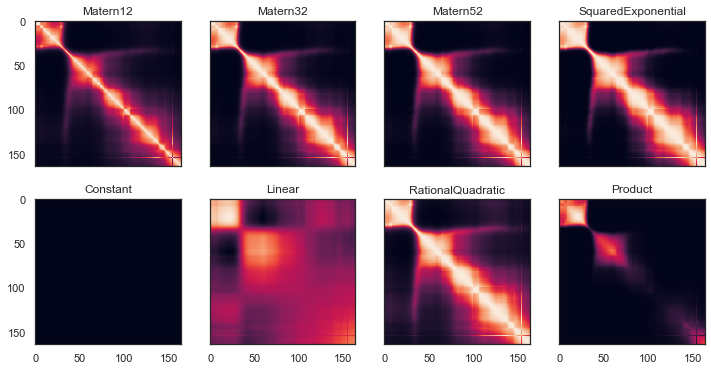

In [28]:
np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 0])
plotkernels(gpflow.kernels.Matern32(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 1])
plotkernels(gpflow.kernels.Matern52(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 2])
plotkernels(gpflow.kernels.RBF(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 3])
plotkernels(gpflow.kernels.Constant(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 0])
plotkernels(gpflow.kernels.Linear(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 1])
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 2])
plotkernels(k, final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 3])

np.random.seed(1234)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernels(gpflow.kernels.Matern12(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 0], cov=True)
plotkernels(gpflow.kernels.Matern32(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 1], cov=True)
plotkernels(gpflow.kernels.Matern52(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 2], cov=True)
plotkernels(gpflow.kernels.RBF(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[0, 3], cov=True)
plotkernels(gpflow.kernels.Constant(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 0], cov=True)
plotkernels(gpflow.kernels.Linear(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 1], cov=True)
plotkernels(gpflow.kernels.RationalQuadratic(), final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 2], cov=True)
plotkernels(k, final_data_us[["SI", "HOME", "WORK", "OTHER"]], ma=True, ax=axes[1, 3], cov=True)

In [82]:
### Expand Mobility Data Kernels

# Variational Bayesian non-parametric inference for infectious disease models

In this approach we follow Hensman and Kypraios paper. 

1. $\lambda(t)$ = exp($f$(t)); the GP model depends only on time
2. $\lambda(t)$ = $\beta(t)$S(t)I(t) with $\beta(t)$ = exp($f$(t)); the GP model allows the person to person infenction to be non-constant and time-varying
3. $\lambda(t)$ = exp($f$(S(t)I(t))); the GP model is a function of the product S(t)I(t)

In [94]:
def plot_prediction(X, Y, model, X_test=None, Y_test=None, num_samples=20):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    
    Xnew = np.linspace(X.min(axis=0) - 0.5, X.max(axis=0) + 0.5, 100)
    Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=num_samples)
    mean, var = model.predict_f(Xnew)
    
    ax.plot(Xnew.flatten(), np.squeeze(Ypred).T, "C1", alpha=0.2)
    ax.plot(Xnew.flatten(), mean, "-", c="C0")
    
    lo = (mean - 2 * tf.sqrt(var)).numpy()
    hi = (mean + 2 * tf.sqrt(var)).numpy()
    ax.fill_between(Xnew.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(X, Y, "o", c="C2", alpha=0.7, label="train")
    if (X_test is not None) and (Y_test is not None):
        ax.plot(X_test, Y_test, "o", c="C3", alpha=0.7, label="test")
        ax.legend()

In [195]:
def plot_model(Y, Y_mean, Y_var, test=False):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    
    if test==False:
        X = final_data_us[["Updated"]][:split]
    else:
        X = final_data_us[["Updated"]][split:]
    
    lo = (Y_mean - 2 * tf.sqrt(Y_var)).numpy()
    hi = (Y_mean + 2 * tf.sqrt(Y_var)).numpy()
    
    ax.plot(X, Y, "o", c="brown", label="Daily COVID cases")
    ax.plot(X, Y_mean, "-", c="blue", label="Average COVID prediction")
    ax.fill_between(X.to_numpy().flatten(), lo.flatten(), hi.flatten(), alpha=0.3, interpolate=True)


### MODEL 1:

$\lambda(t)$ = exp($f$(t)); the GP model depends only on time

In [66]:
final_data_us

,Updated,Confirmed,Deaths,Recovered,I,Daily,S,Date_number,WEEKDAY,HOME,WORK,OTHER,SI
24,2020-02-15,15.0,1.0,0.0,14.0,0.0,327999986.0,26.0,0.0,-1.0,2.0,6.50,4.592000e+09
25,2020-02-16,15.0,1.0,0.0,14.0,0.0,327999986.0,27.0,0.0,-1.0,0.0,6.50,4.592000e+09
26,2020-02-17,18.0,2.0,0.0,16.0,3.0,327999984.0,28.0,1.0,5.0,-24.0,6.25,5.248000e+09
27,2020-02-18,21.0,2.0,3.0,16.0,3.0,327999984.0,29.0,1.0,1.0,0.0,1.50,5.248000e+09
28,2020-02-19,24.0,2.0,3.0,19.0,3.0,327999981.0,30.0,1.0,0.0,1.0,2.75,6.232000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-23,3973169.0,133151.0,1226670.0,2613348.0,70719.0,325386652.0,185.0,1.0,11.0,-37.0,2.00,8.503486e+14
184,2020-07-24,4047529.0,134301.0,1252170.0,2661058.0,74360.0,325338942.0,186.0,1.0,11.0,-37.0,1.00,8.657458e+14
185,2020-07-25,4113473.0,135286.0,1277437.0,2700750.0,65944.0,325299250.0,187.0,0.0,4.0,-13.0,8.75,8.785519e+14
186,2020-07-26,4172104.0,135838.0,1296612.0,2739654.0,58631.0,325260346.0,188.0,0.0,3.0,-16.0,4.75,8.911008e+14


In [29]:
y = final_data_us["Daily"].to_numpy()
X = final_data_us[["Date_number"]].to_numpy()

y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))

In [166]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


**Likelihood**: The likelihood of the observed data is Poisson distribution

In [ ]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Poisson(), kernel=k)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, variables=m.trainable_variables, options=dict(maxiter=20000))
print_summary(m)

In [167]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

In [168]:
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.7875825070929646
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0924837286149793
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.7875825070929688
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.7875825070929643
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.3281233240723358
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,4.46964878705061
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.022904575840653495
VGP.q_mu,Parameter,Identity,,False,"(144, 1)",float64,[[-1.08046815...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 144, 144)",float64,"[[[7.87909501e-02, 0.00000000e+00, 0.00000000e+00..."


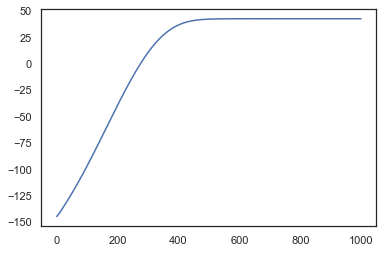

In [169]:
# ELBO
plt.plot(logf)

In [170]:
mean, var = m.predict_f(X_train)

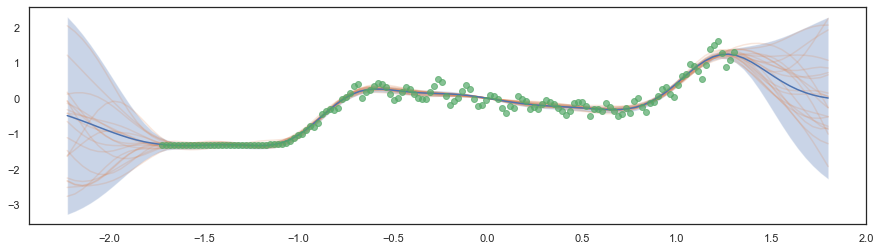

In [171]:
plot_prediction(X_train, y_train, m, X_test=None, Y_test=None, num_samples=20)

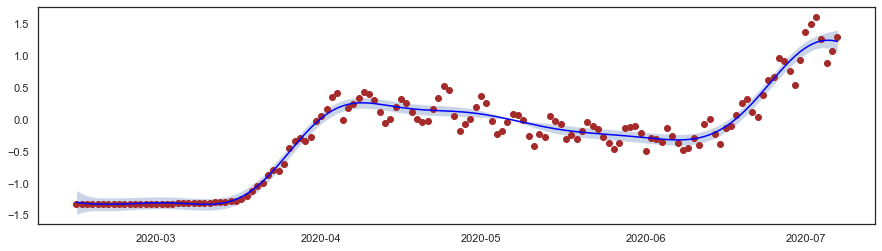

In [172]:
plot_model(y_train, mean, var)

In [36]:
np.mean(var)

0.0019881585191679515

### Comments

The results from M1 $\lambda(t)$ = exp($f$(t)) have several issues

1. The results $\lambda(t)$ is at a much lower level than the actual values. In fact, we need to multiply the average value by $2,000$
2. Compared to Hensman's approach (Fig 9.6, synthetic Data 1) the $\lambda(t)$ generated correct numbers; here it seems to significantly deflate the numbers. Also, with Hensman synthetic Data 2, Fig 9.9 is ok. But, for Abakaliki Smallpox data Fig. 9.10 is much different, deflating the results. I think they get deflated results and then multiplied them by a factor.
3. In general, the model manages to capture the general pattern of the infenctions. 
4. For time we used just the number of dates, for example the dates start from 2020-02-15 so t_1 = 26th day from the START of the pandemic in US

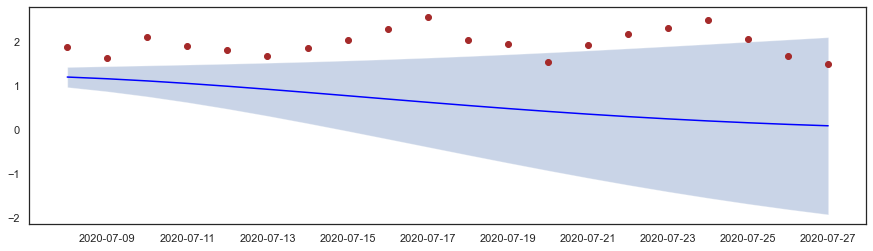

In [173]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [174]:
var_test

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[0.01308052],
       [0.02043794],
       [0.031122  ],
       [0.04592907],
       [0.06563786],
       [0.09095464],
       [0.1224597 ],
       [0.1605608 ],
       [0.20545847],
       [0.25712652],
       [0.3153094 ],
       [0.37953619],
       [0.44914894],
       [0.52334229],
       [0.60120998],
       [0.68179397],
       [0.76413213],
       [0.84730102],
       [0.93045134],
       [1.01283464]])>

The test fails to capture the test data. 

We will try the UK data too. To see how it fits that data.

### MODEL 2:

$\lambda(t)$ = $\beta(t)$S(t)I(t) with $\beta(t)$ = exp($f$(t)); the GP model allows the person to person infenction to be non-constant and time-varying

In [43]:
final_data_us

,Updated,Confirmed,Deaths,Recovered,I,Daily,S,Date_number,WEEKDAY,HOME,WORK,OTHER
24,2020-02-15,15.0,1.0,0.0,14.0,0.0,327999986.0,26.0,0.0,0.99,1.02,1.0650
25,2020-02-16,15.0,1.0,0.0,14.0,0.0,327999986.0,27.0,0.0,0.99,1.00,1.0650
26,2020-02-17,18.0,2.0,0.0,16.0,3.0,327999984.0,28.0,1.0,1.05,0.76,1.0625
27,2020-02-18,21.0,2.0,3.0,16.0,3.0,327999984.0,29.0,1.0,1.01,1.00,1.0150
28,2020-02-19,24.0,2.0,3.0,19.0,3.0,327999981.0,30.0,1.0,1.00,1.01,1.0275
...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-23,3973169.0,133151.0,1226670.0,2613348.0,70719.0,325386652.0,185.0,1.0,1.11,0.63,1.0200
184,2020-07-24,4047529.0,134301.0,1252170.0,2661058.0,74360.0,325338942.0,186.0,1.0,1.11,0.63,1.0100
185,2020-07-25,4113473.0,135286.0,1277437.0,2700750.0,65944.0,325299250.0,187.0,0.0,1.04,0.87,1.0875
186,2020-07-26,4172104.0,135838.0,1296612.0,2739654.0,58631.0,325260346.0,188.0,0.0,1.03,0.84,1.0475


/Users/georgiospapadopoulos/opt/anaconda3/envs/argos/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


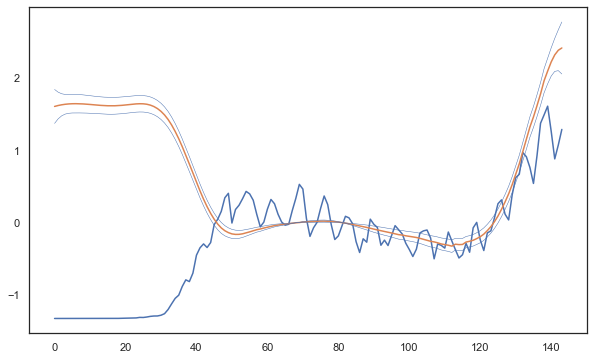

In [231]:
plt.figure(figsize=(10,6))
plt.plot(y_train)
factors_SI = final_data_us.S[:split]*final_data_us.I[:split]
factors_SI = preprocessing.scale(factors_SI)

plt.plot(mean.numpy().reshape((-1,))*factors_SI)
plt.plot(mean.numpy().reshape((-1,))*factors_SI + 2 * np.sqrt(var.numpy().reshape((-1,)))*factors_SI, "C0", lw=0.5)
plt.plot(mean.numpy().reshape((-1,))*factors_SI - 2 * np.sqrt(var.numpy().reshape((-1,)))*factors_SI, "C0", lw=0.5)

/Users/georgiospapadopoulos/opt/anaconda3/envs/argos/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


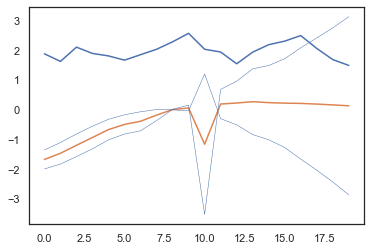

In [230]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)
factors_SI = final_data_us.S[split:]*final_data_us.I[split:]
factors_SI = factors_SI.to_numpy()
factors_SI = preprocessing.scale(factors_SI)

plt.plot(y_test)
plt.plot(mean_test.numpy().reshape((-1,))*factors_SI)
plt.plot(mean_test.numpy().reshape((-1,))*factors_SI + 2 * np.sqrt(var_test.numpy().reshape((-1,)))*factors_SI, "C0", lw=0.5)
plt.plot(mean_test.numpy().reshape((-1,))*factors_SI - 2 * np.sqrt(var_test.numpy().reshape((-1,)))*factors_SI, "C0", lw=0.5)

## Model 3

$\lambda(t)$ = exp($f$(S(t)I(t)))

In [175]:
y = final_data_us["Daily"].to_numpy()
X = final_data_us["SI"].to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [176]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


In [177]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

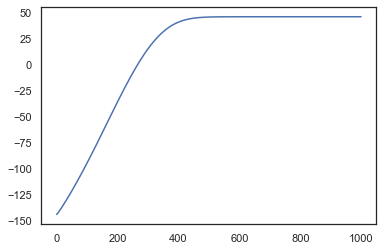

In [178]:
# ELBO
plt.plot(logf)

In [179]:
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.1575541296920733
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.4787669361509602
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.1575541296920988
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.1575541296920542
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.300197940032309
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,4.276910295539832
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.02369129340847952
VGP.q_mu,Parameter,Identity,,False,"(144, 1)",float64,[[-8.66093777e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 144, 144)",float64,"[[[1.71817410e-02, 0.00000000e+00, 0.00000000e+00..."


In [180]:
mean, var = m.predict_f(X_train)

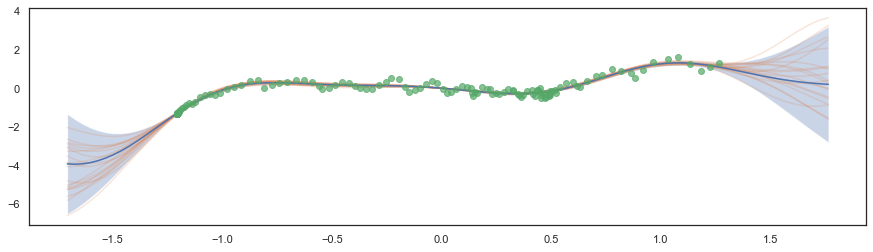

In [181]:
plot_prediction(X_train, y_train, m, X_test=None, Y_test=None, num_samples=20)

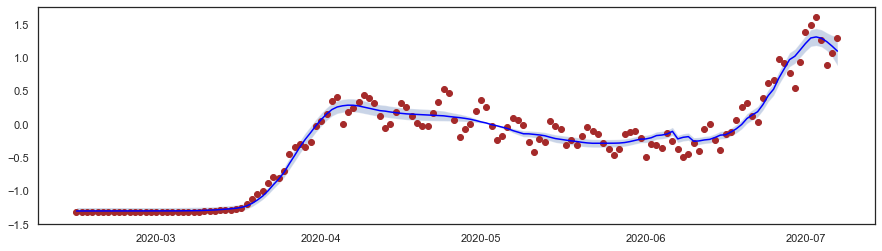

In [182]:
plot_model(y_train, mean, var)

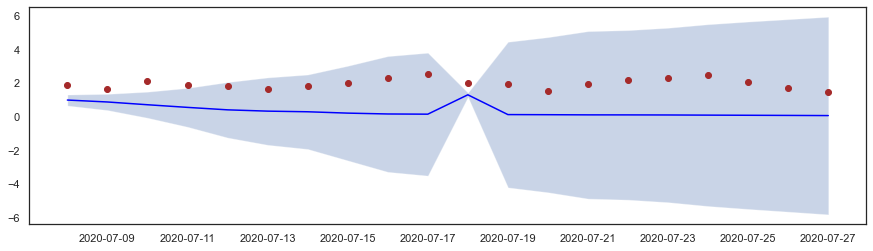

In [183]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [185]:
var_test

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[2.66949770e-02],
       [5.83626873e-02],
       [1.50775560e-01],
       [3.34713697e-01],
       [6.81410035e-01],
       [1.00426466e+00],
       [1.22618647e+00],
       [1.98220955e+00],
       [2.96285995e+00],
       [3.34070595e+00],
       [4.08025914e-03],
       [4.69021277e+00],
       [5.32430625e+00],
       [6.20187759e+00],
       [6.35798269e+00],
       [6.72891668e+00],
       [7.31083355e+00],
       [7.76689981e+00],
       [8.19462972e+00],
       [8.63786463e+00]])>

## Alternative method

$\lambda(t)$ = $f$(S(t)I(t) + WKDAY(t) + HOME(t) + WORK(t) + OTHER(t))

In [186]:
y = final_data_us["Daily"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME", "WORK", "OTHER"]].to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [188]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


In [189]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

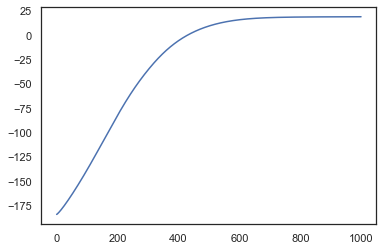

In [169]:
# ELBO
plt.plot(logf)

In [190]:
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.6319396146774953
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,3.698499261691184
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.6319396146774968
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.631939614677497
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.5385472942024285
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.12354701663457451
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.010579604247698727
VGP.q_mu,Parameter,Identity,,False,"(144, 1)",float64,[[-0.80018873...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 144, 144)",float64,"[[[4.40964690e-02, 0.00000000e+00, 0.00000000e+00..."


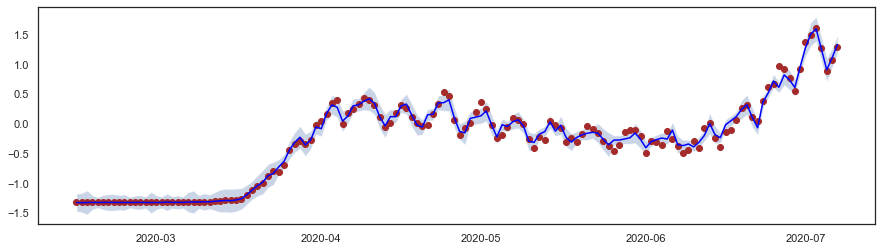

In [192]:
mean, var = m.predict_f(X_train)

plot_model(y_train, mean, var)

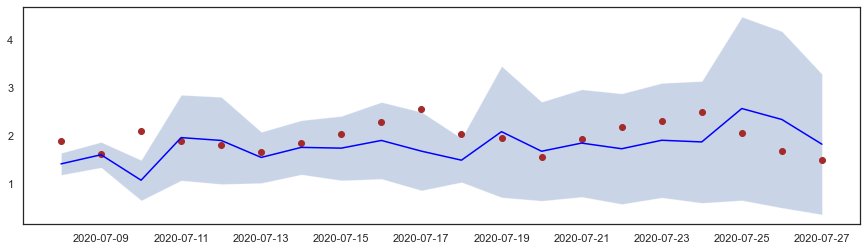

In [196]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [194]:
var_test

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[0.01327357],
       [0.01785915],
       [0.04485168],
       [0.20088465],
       [0.20831818],
       [0.07180383],
       [0.08056734],
       [0.113726  ],
       [0.1616692 ],
       [0.16875554],
       [0.05313302],
       [0.47293893],
       [0.26872426],
       [0.31692162],
       [0.33485775],
       [0.36001265],
       [0.40679244],
       [0.92407658],
       [0.85554701],
       [0.5409976 ]])>

## Alternative 2

$\lambda(t)$ = $f$(S(t)I(t) + WEEKDAY(t) + HOME(t).avrgsmth(7) + WORK(t).avrgsmth(7) + OTHER(t).avrgsmth(7))

In [197]:
final_data_us[["HOME", "WORK", "OTHER"]].rolling(7).mean().fillna(1)

,HOME,WORK,OTHER
24,1.000000,1.000000,1.000000
25,1.000000,1.000000,1.000000
26,1.000000,1.000000,1.000000
27,1.000000,1.000000,1.000000
28,1.000000,1.000000,1.000000
...,...,...,...
183,8.714286,-30.857143,2.428571
184,8.714286,-30.857143,2.392857
185,8.714286,-30.857143,2.464286
186,8.714286,-30.857143,2.607143


In [206]:
y = final_data_us["Daily"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME", "WORK", "OTHER"]].copy()
X[["HOME", "WORK", "OTHER"]] = final_data_us[["HOME", "WORK", "OTHER"]].rolling(7).mean().fillna(1)
X = X.to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [207]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


In [208]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

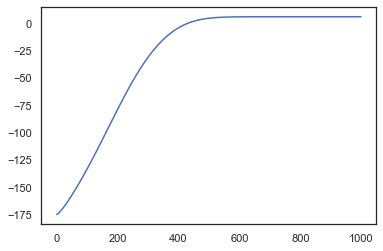

In [209]:
# ELBO
plt.plot(logf)

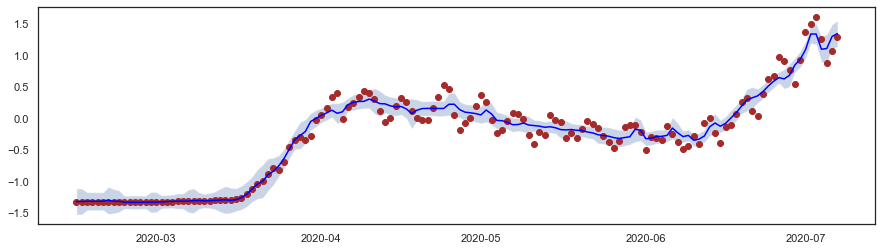

In [210]:
mean, var = m.predict_f(X_train)

plot_model(y_train, mean, var)

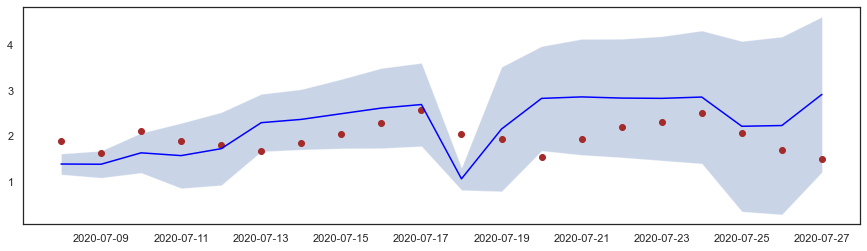

In [211]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [212]:
var_test

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[0.01296134],
       [0.02181189],
       [0.04799159],
       [0.12835681],
       [0.16036378],
       [0.09959811],
       [0.10977018],
       [0.14493395],
       [0.19347359],
       [0.20949383],
       [0.01516728],
       [0.4678407 ],
       [0.32994693],
       [0.40563947],
       [0.42415714],
       [0.465384  ],
       [0.53320606],
       [0.87602443],
       [0.95379728],
       [0.72795863]])>

## Alternative Model 2: Test the Effect of Mobility Data

In [235]:
y = final_data_us["Daily"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "WORK", "OTHER"]].copy()
X[["WORK", "OTHER"]] = final_data_us[["WORK", "OTHER"]].rolling(7).mean().fillna(1)
X = X.to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


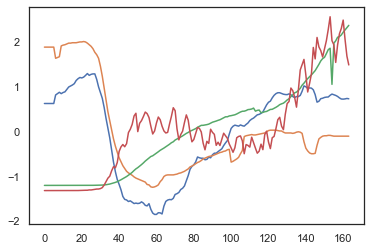

In [236]:
plt.plot(X[:,3])
plt.plot(X[:,2])
plt.plot(X[:,0])
plt.plot(y)

In [214]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


In [215]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

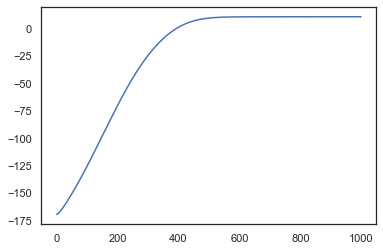

In [216]:
# ELBO
plt.plot(logf)

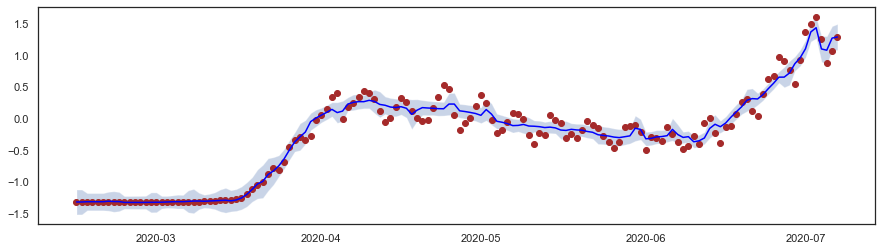

In [217]:
mean, var = m.predict_f(X_train)

plot_model(y_train, mean, var)

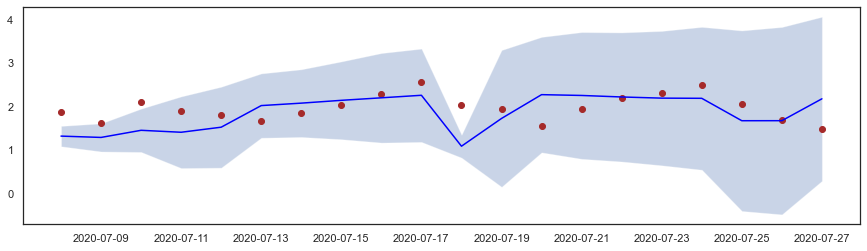

In [218]:

mean_test, var_test = m.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

In [219]:
y = final_data_us["Daily"].to_numpy()
X = final_data_us[["SI", "WEEKDAY", "HOME"]].copy()
X[["HOME"]] = final_data_us[["HOME"]].rolling(7).mean().fillna(1)
X = X.to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


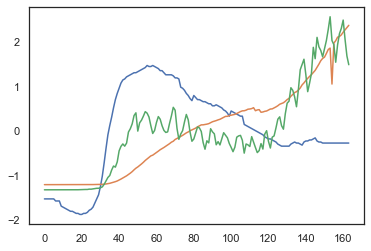

In [234]:
plt.plot(X[:,2])
plt.plot(X[:,0])
plt.plot(y)

In [220]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


In [221]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

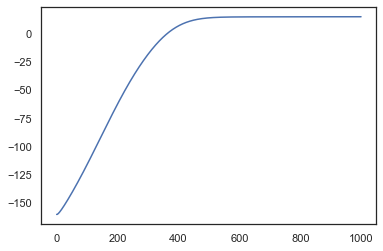

In [222]:
# ELBO
plt.plot(logf)

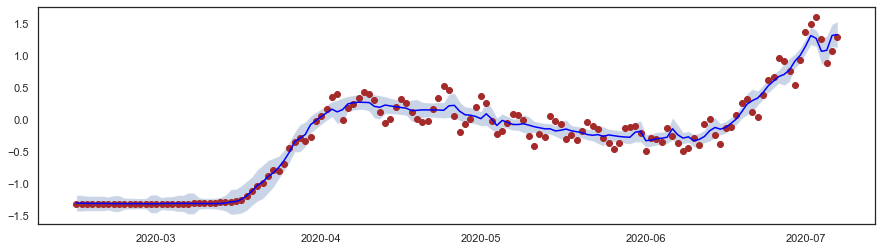

In [223]:
mean, var = m.predict_f(X_train)

plot_model(y_train, mean, var)

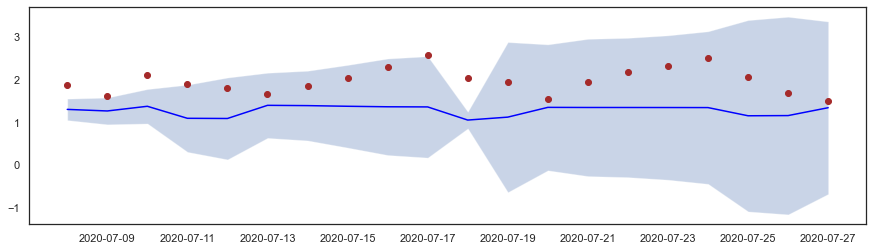

In [224]:
mean_test, var_test = m.predict_f(X_test)

plot_model(y_test, mean_test, var_test, test=True)

## Alternative Model 3: Multioutput

In [237]:
y = final_data_us[["Daily", "Recovered"]].to_numpy()
X = final_data_us[["SI", "I", "WEEKDAY", "HOME", "WORK", "OTHER"]].to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


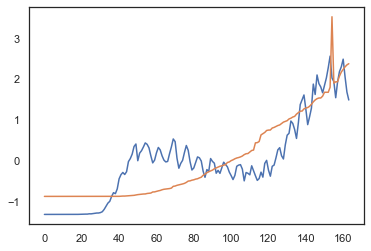

In [242]:
plt.plot(y[:,0])
plt.plot(y[:,1])

In [238]:
print("The Y dimensions are {0} rows and {1} columns; the X dimensions are {2} rows and {3} columns.".format(y.shape[0], y.shape[1], X.shape[0], X.shape[1]))

The Y dimensions are 164 rows and 2 columns; the X dimensions are 164 rows and 6 columns.


In [239]:
# Base kernel
SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE * LIN * RQ

# Create list of kernels for each output
kern_list = [k for _ in range(y.shape[1])]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

print_summary(kernel, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SeparateIndependent.kernels[0].kernels[0].variance SeparateIndependent.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[0].lengthscales SeparateIndependent.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[1].variance SeparateIndependent.kernels[1].kernels[1].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[2].variance SeparateIndependent.kernels[1].kernels[2].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[2].lengthscales SeparateIndependent.kernels[1].kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[2].alpha SeparateIndependent.kernels[1].kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


In [252]:
SE = gpflow.kernels.SquaredExponential(active_dims=[0, 2, 3, 4, 5])
LIN = gpflow.kernels.Linear(active_dims=[0, 2, 3, 4, 5])
RQ = gpflow.kernels.RationalQuadratic(active_dims=[0, 2, 3, 4, 5])
k1 = SE * LIN * RQ

SE = gpflow.kernels.SquaredExponential(active_dims=[1, 2, 3, 4, 5])
LIN = gpflow.kernels.Linear(active_dims=[1, 2, 3, 4, 5])
RQ = gpflow.kernels.RationalQuadratic(active_dims=[1, 2, 3, 4, 5])
k2 = SE * LIN * RQ

# Create list of kernels for each output
kern_list = [k1, k2]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

print_summary(kernel, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SeparateIndependent.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[2].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[0].kernels[2].alpha,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[1].kernels[1].variance,Parameter,Softplus,,True,(),float64,1
SeparateIndependent.kernels[1].kernels[2].variance,Parameter,Softplus,,True,(),float64,1


In [ ]:
m = gpflow.models.SVGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=kernel, num_latent_gps=y.shape[1])

maxiter = ci_niter(1000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [ ]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=kernel, num_latent_gps=y.shape[1])

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

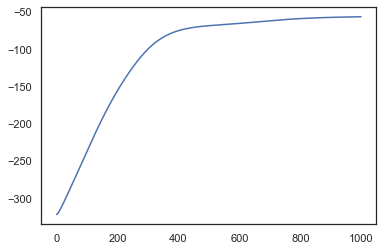

In [204]:
# ELBO
plt.plot(logf)

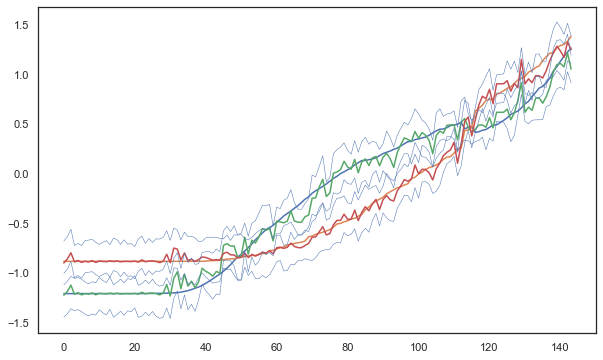

In [205]:
mean, var = m.predict_f(X_train)

plt.figure(figsize=(10,6))
plt.plot(y_train)
plt.plot(mean)
plt.plot(mean + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(mean - 2 * np.sqrt(var), "C0", lw=0.5)

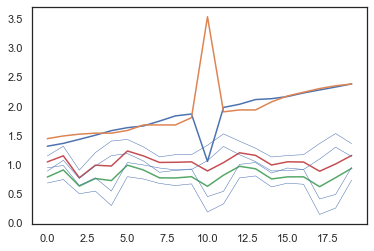

In [206]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)

plt.plot(y_test)
plt.plot(mean_test)
plt.plot(mean_test + 2 * np.sqrt(var_test), "C0", lw=0.5)
plt.plot(mean_test - 2 * np.sqrt(var_test), "C0", lw=0.5)

## Alternative Model 4: Multioutput

In [207]:
y = final_data_us[["I", "Recovered"]].to_numpy()
X = final_data_us[["SI", "HOME", "WORK", "OTHER"]].copy()
X[["HOME", "WORK", "OTHER"]] = final_data_us[["HOME", "WORK", "OTHER"]].rolling(7).mean().fillna(1)
X = X.to_numpy()


y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

/Users/georgiospapadopoulos/opt/anaconda3/envs/argos/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [208]:
# Base kernel
SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE * LIN * RQ

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=y.shape[1], rank=0, active_dims=[1])

kern = k * coreg
print_summary(kern)

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value   │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Product.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─

In [209]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=kernel, num_latent_gps=y.shape[1])

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

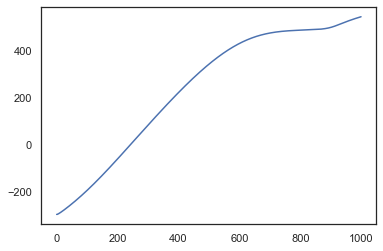

In [210]:
# ELBO
plt.plot(logf)

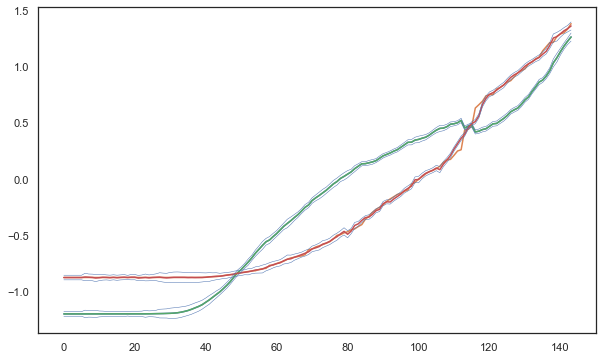

In [211]:
mean, var = m.predict_f(X_train)

plt.figure(figsize=(10,6))
plt.plot(y_train)
plt.plot(mean)
plt.plot(mean + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(mean - 2 * np.sqrt(var), "C0", lw=0.5)

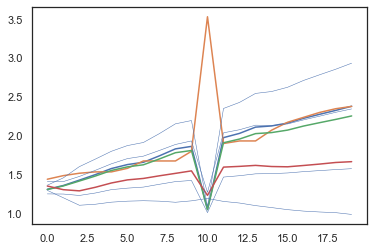

In [212]:
# The test US data are

mean_test, var_test = m.predict_f(X_test)

plt.plot(y_test)
plt.plot(mean_test)
plt.plot(mean_test + 2 * np.sqrt(var_test), "C0", lw=0.5)
plt.plot(mean_test - 2 * np.sqrt(var_test), "C0", lw=0.5)

## Alternative Model 5: Multioutput